# Building Filters

Dependencies

In [22]:
import numpy as np
import math
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.integrate import quad
from scipy.integrate import dblquad
from scipy.integrate import tplquad
from scipy.ndimage import rotate as scipy_rotate
from scipy.ndimage import shift as scipy_shift
from joblib import Parallel, delayed

## Constructing 2D Video filters (embedding of T(K^t) into C(R^2 x R, R))

In [23]:
def formula(x,y,t,th1,th2,r,u,v,w):
    x = float(x)
    y = float(y)
    t = float(t)
    th1 = float(th1)
    th2 = float(th2)
    r = float(r)
    u = float(u)
    v = float(v)
    w = float(w)
    
    assert(th1 < np.pi and th1 >= 0)
    assert(th2 < 2*np.pi and th2 >= 0)

    def q2(a):
        a = 2*a - 1
        return(a)

    def q3(a):
        a = 2*a - 1
        a =3*(a**2)-1
        #a =((3*(a**2)-1)/2)
        return a

    return np.sin(th2 + t*v)*q2(np.cos(th1+t*u)*(x+(r+t*w)*np.cos(th1+t*u)) + np.sin(th1+t*u)*(y+(r+t*w)*np.sin(th1+t*u))) \
            + np.cos(th2 + t*v)*q3(np.cos(th1+t*u)*(x+(r+t*w)*(np.cos(th1+t*u))) + np.sin(th1+t*u)*(y+(r+t*w)*(np.sin(th1+t*u))))


def six_klein_bottle(num_th1=8, num_th2=8, num_r=8, num_u=8, num_v=8, num_w=8, width=5, time=5, thresh=None):
    
    angles1 = [ float(i * np.pi) / num_th1 for i in range(num_th1) ]
    angles2 = [ float(i * 2*np.pi) / num_th2 for i in range(num_th2) ]
    r_vals = [ (2*float(i)-(num_r-1)) / (num_r-1) for i in range(num_r)]
    u_vals = [ (2*float(i)-(num_u-1)) / (num_u-1) for i in range(num_u)]
    v_vals = [ (2*float(i)-(num_v-1)) / (num_v-1) for i in range(num_v)]
    w_vals = [ (2*float(i)-(num_w-1)) / (num_w-1) for i in range(num_w)]
    
    weights = np.zeros((num_th1,num_th2,num_r,num_u,num_v,num_w,width,width,time))
    for ti in range(len(angles1)):
        print('th1: '+str(ti))
        for tj in range(len(angles2)):
            print('th2: '+str(tj))
            for tr in range(len(r_vals)):
                for tu in range(len(u_vals)):
                    for tv in range(len(v_vals)):
                        for tw in range(len(w_vals)):
                            th1, th2, r, u, v, w = angles1[ti], angles2[tj], r_vals[tr], u_vals[tu], v_vals[tv], w_vals[tw]
                            M = np.zeros([time, width, width])
                            for i in range(width):
                                for j in range(width):
                                    for k in range(time):
                                        x1 = i * 1.0 / width
                                        x2 = x1 + 1.0 / width
                                        y1 = j * 1.0 / width
                                        y2 = y1 + 1.0 / width
                                        t1 = k * 1.0/ time
                                        t2 = t1 + 1.0/ time
                                        I = tplquad(formula,t1,t2,y1,y2,x1,x2,args=(th1,th2,r,u,v,w))
                                        value = I[0]
                                        M[k,i,j] = value
                            M = M - np.mean(M)
                            M = M / np.std(M.flatten())
                            if thresh:
                                M[M>=thresh]=1
                                M[M<thresh]=0
                            weights[ti,tj,tr,tu,tv,tw,:,:,:] = M
    return weights


In [78]:
#S^0 bundle over the Klein bottle

def moving_klein_bottle(num_th1=8, num_th2=8, width=5, time=5, thresh=None):
    
    angles1 = [ float(i * np.pi) / num_th1 for i in range(num_th1) ]
    angles2 = [ float(i * 2*np.pi) / num_th2 for i in range(num_th2) ]
    wvals = [-1,0.0,1]
    
    weights = np.zeros((num_th1,num_th2,3,time,width,width))
    for ti in range(len(angles1)):
        print('th1: '+str(ti))
        for tj in range(len(angles2)):
            print('th2: '+str(tj))
            for tw in range(3):
                th1, th2, w = angles1[ti], angles2[tj], wvals[tw]
                M = np.zeros([time, width, width])
                for i in range(width):
                    for j in range(width):
                        for k in range(time):
                            x1 = i * 1.0 / width
                            x2 = x1 + 1.0 / width
                            y1 = j * 1.0 / width
                            y2 = y1 + 1.0 / width
                            t1 = k * 2.0/time - 1.0
                            t2 = t1 + 2.0/ time
                            #print('x: '+str((x1+x2)/2)+' '+'y: '+str((y1+y2)/2)+' '+'t: '+str((t1+t2)/2)+' '+'th1: '+str(th1)+' '+'th2: '+str(th2)+' '+'w: '+str(w))
                            #value = formula((x1+x2)/2,(y1+y2)/2,(t1+t2)/2,th1,th2,0,0,0,w)
                            I = tplquad(formula,t1,t2,y1,y2,x1,x2,args=(th1,th2,0,0,0,w))
                            value = I[0]
                            M[k,i,j] = value
                M = M - np.mean(M)
                M = M / np.std(M.flatten())
                if thresh:
                    M[M>=thresh]=1
                    M[M<thresh]=0
                weights[ti,tj,tw,:,:,:] = M
    return weights


## Make and save filters

In [ ]:
#grids = six_klein_bottle(4,4,3,3,3,3,3,3,None)
#grids = six_klein_bottle(8,8,4,4,4,4,3,3,None)
start = time.time()
grids = moving_klein_bottle(8,8,5,5,None)
end = time.time()
print(end - start)

#f = open('sixklein443333-333.npy','wb')
#np.save(f, grids)

In [178]:
def moving_klein_bottle_par(num_th1=8, num_th2=8, width=5, time=5, thresh=None, n_jobs=1):
    
    angles1 = [ float(i * np.pi) / num_th1 for i in range(num_th1) ]
    angles2 = [ float(i * 2*np.pi) / num_th2 for i in range(num_th2) ]
    wvals = [-1,0.0,1]
    
    weights = np.zeros((num_th1,num_th2,3,time,width,width))
    z1 = [(ti,th1,tj,th2,tw,w) for ti,th1 in enumerate(angles1) for tj,th2 in enumerate(angles2) for tw,w in enumerate(wvals)]
    z = []
    for i in range(width): 
        for j in range(width):
            for k in range(time):
                x1 = i * 1.0 / width
                x2 = x1 + 1.0 / width
                y1 = j * 1.0 / width
                y2 = y1 + 1.0 / width
                t1 = k * 2.0/time - 1.0
                t2 = t1 + 2.0/ time
                z.append((x1,x2,y1,y2,t1,t2,i,j,k))

    def grid_calc(th1,th2,w,width,time,z):
        M = np.zeros([time, width, width])
        for x1,x2,y1,y2,t1,t2,i,j,k in z:
            M[k,i,j] = tplquad(formula,t1,t2,y1,y2,x1,x2,args=(th1,th2,0,0,0,w))[0]        
        M = M - np.mean(M)
        M = M / np.std(M.flatten())
        if thresh:
            M[M>=thresh]=1
            M[M<thresh]=0
        return(M)
            
    def one_run(item):
        ti,th1,tj,th2,tw,w = item
        return(grid_calc(th1,th2,w,width,time,z))
        
    r = Parallel(n_jobs=n_jobs)(delayed(one_run)(item) for item in z1)
    
    for i, item in enumerate(z1):
        ti,th1,tj,th2,tw,w = item
        weights[ti,tj,tw,...]=r[i]
            
    return weights

In [80]:
start = time.time()
grids = moving_klein_bottle(2,2,5,5,None)
end = time.time()
print(end - start)

th1: 0
th2: 0
th2: 1
th1: 1
th2: 0
th2: 1
250.38836526870728


In [185]:
start = time.time()
grids2 = moving_klein_bottle_par(8,8,5,5,None, n_jobs=60)
end = time.time()
print(end - start)

144.12840867042542


In [191]:
grids2_flat = grids2.reshape(-1, *filters.shape[-3:])

In [197]:
np.sum([np.all(grid==gridj) for i,grid in enumerate(grids2_flat) for j,gridj in enumerate(grids2_flat)])

192

In [36]:
# TODO: Test if the 8x8 matches Ben's work

In [198]:
for i,grid in enumerate(grids2_flat):
    print(grid.shape)
    break

(5, 5, 5)


In [199]:
f = open('/home/ephy/Projects/tda_convolve_video/src/python3/movingklein88-555.npy','rb')
# f = open('sixklein443333-333.npy','rb')

filters = np.load(f)
filters_flat = filters.reshape(-1, *filters.shape[-3:])
print(filters.shape)
print(filters_flat.shape)

(8, 8, 3, 5, 5, 5)
(192, 5, 5, 5)


## Animate filters

In [202]:
%matplotlib notebook

<IPython.core.display.Javascript object>


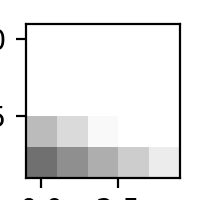

In [242]:
figs = plt.figure(0, figsize=(1,1))
grid = grids2[7,2,2,...]
ims = [[plt.imshow(gridframe, cmap='gray', vmin=0, vmax=1, animated=True)] for gridframe in grid]
anis = animation.ArtistAnimation(figs, ims, interval=500, blit=True, repeat_delay=200)

plt.show()